# Access data with Iceberg
Data stored in the datalake can be accessed programmatically, by using a client such as *pyiceberg*.

The steps are:

1. Install the dependencies
2. Access the catalogue to discover tables
3. Load a table
4. Read data by defining filters or projections

The notebook will guide users during the steps, providing a working example which can be used as a starting point or a template.

**Note: Credentials and authorization policies are handled by the platform. Users do not need to input tokens or passwords when working inside the platform, because those are already handled in the background.**

In [2]:
# install dependencies
%pip install pyiceberg==0.8.0 pyiceberg[s3fs,sql-sqlite]

  Using cached pyiceberg-0.8.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (822 kB)
  Using cached fsspec-2024.12.0-py3-none-any.whl (183 kB)
  Using cached mmh3-5.0.1-cp310-cp310-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_17_x86_64.manylinux2014_x86_64.whl (93 kB)
  Using cached rich-13.9.4-py3-none-any.whl (242 kB)
  Using cached sortedcontainers-2.4.0-py2.py3-none-any.whl (29 kB)
  Using cached strictyaml-1.7.3-py3-none-any.whl (123 kB)
  Using cached tenacity-9.0.0-py3-none-any.whl (28 kB)
  Using cached SQLAlchemy-2.0.37-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (3.1 MB)
  Using cached s3fs-2024.12.0-py3-none-any.whl (30 kB)
  Using cached markdown_it_py-3.0.0-py3-none-any.whl (87 kB)
  Using cached aiobotocore-2.18.0-py3-none-any.whl (77 kB)
  Using cached aiohttp-3.11.11-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (1.6 MB)
  Using cached aioitertools-0.12.0-py3-none-any.whl (24 kB)
  Using cached botocore-1.36.1-py3-none-any

# Access the catalogue

Load the catalogue from the URL and view namespaces and tables

In [1]:
from pyiceberg.catalog import load_catalog

# Set up the connection to ai4trust Catalog named `iceberg`
catalog = load_catalog("iceberg")

# Verify connection by listing namespaces
namespaces = catalog.list_namespaces()
print("Namespaces:", namespaces)


Namespaces: [('news',), ('telegram',), ('tools',), ('youtube',)]


In [2]:
# list tables for namespace news
tables = catalog.list_tables("news")
print(tables)

[('news', 'approved_articles'), ('news', 'collected_news'), ('news', 'fetched_articles'), ('news', 'search_parameters')]


## Load a table and explore the metadata

By loading a table we can inspect the schema and the properties

https://py.iceberg.apache.org/api/#catalog-table



In [3]:
# Load the table from the catalog
table = catalog.load_table("news.collected_news")

In [4]:
#get the table schema
schema = table.schema()
print(schema)

table {
  1: created_at: optional string
  2: image_hash: optional string
  3: language: optional string
  4: fetched_id: optional string
  5: title: optional string
  6: data_owner: optional string
  7: source_url: optional string
  8: sourcecountry: optional string
  9: id: optional string
  10: text: optional string
  11: keyword: optional string
  12: _timestamp: optional long
  13: summary: optional string
  14: _table: optional string
  15: image_url: optional string
  16: socialimage: optional string
  17: url: optional string
  18: search_id: optional string
  19: url_mobile: optional string
  20: search_date: optional string
  21: keyword_id: optional string
  22: domain: optional string
  23: seendate: optional string
  24: publish_date: optional string
  25: authors: optional list<string>
  27: image_path: optional string
}


In [7]:
# Get the table properties
properties = table.properties
print(properties)

{'nessie.catalog.content-id': 'e465ccdf-6813-4c2d-8a13-6264af38bf2d', 'write.metadata.delete-after-commit.enabled': 'false', 'nessie.commit.id': '31a3c3ef291a15b0893d078dfc3ace32365c3a62e949fb3452ff513a7adf0b7a', 'gc.enabled': 'false', 'write.parquet.compression-codec': 'zstd', 'nessie.commit.ref': 'main'}


# Query data

Read from the table a subset of data via filters.

https://py.iceberg.apache.org/api/#query-the-data

We will direcly load results into memory in a pandas dataframe with `to_pandas()`


In [24]:
from pyiceberg.expressions import EqualTo,And

# read all rows where `source_url` matches exactly
SITE="https://www.bbc.com"
df = table.scan(row_filter=And(EqualTo('source_url', SITE), EqualTo('language', 'English'))).to_pandas()


In [25]:
# Check the result 
print(f"Matching rows collected: {len(df)}")

Matching rows collected: 33


In [26]:
# preview
df.head()

,created_at,image_hash,language,fetched_id,title,data_owner,source_url,sourcecountry,id,text,...,url,search_id,url_mobile,search_date,keyword_id,domain,seendate,publish_date,authors,image_path
0,2025-01-21T02:26:32Z,sha256:8805e7d72f97282996b038ca19c20ed3585c6f9...,English,None,"Gaza rebuild will take 'a lot of time', says U...",FBK,https://www.bbc.com,United Kingdom,ea503d53-cb43-4ecf-bc15-358ba86f6188,The rebuilding process in the devastated Pales...,...,https://www.bbc.com/news/articles/c247q99595do,d0b47db8-5534-4550-9175-1447a08d237f,None,None,41,bbc.com,None,2025-01-20T19:01:11.424000+00:00,[David Gritten],s3://warehouse/news/artifacts/imgs/8805/e7d7/2...
1,2025-01-21T02:23:44Z,sha256:07ce1ee67b21c742116ce60b21e8b269933696d...,English,None,'In every street there are dead': Gaza rescuer...,FBK,https://www.bbc.com,United Kingdom,34339a6b-e4c2-4266-ac2d-e23a580f9c9a,On the first full day of peace in Gaza on Mond...,...,https://www.bbc.com/news/articles/cn8x00mgjxmo,9986dc08-61a8-4bfc-ab56-42bb24897c17,None,None,40,bbc.com,None,2025-01-20T20:29:33.115000+00:00,[Joel Gunter],s3://warehouse/news/artifacts/imgs/07ce/1ee6/7...
2,2025-01-21T02:18:26Z,sha256:ede2ec0625e16ec4870f1357dcf87ef004e655a...,English,None,Analysis: The promise and peril of Trump's ina...,FBK,https://www.bbc.com,United Kingdom,b3b788e8-f91b-4dca-b5dd-662e699fecdf,"Donald Trump, who rode back into power on a wa...",...,https://www.bbc.com/news/articles/cj02zmj59r5o,4ae515aa-3a33-4471-a126-1bd84ad5b31b,None,None,38,bbc.com,None,2025-01-20T21:56:19.562000+00:00,[Anthony Zurcher],s3://warehouse/news/artifacts/imgs/ede2/ec06/2...
3,2025-01-21T02:18:41Z,sha256:a2ecfeae013d27caee70871b288de5cba940318...,English,None,Missed Trump's speech? Here are five takeaways,FBK,https://www.bbc.com,United Kingdom,636b220a-3199-4f27-b233-dffec18ec9f0,Donald Trump has been sworn in as the 47th pre...,...,https://www.bbc.com/news/articles/cqld620504wo,4ae515aa-3a33-4471-a126-1bd84ad5b31b,None,None,38,bbc.com,None,2025-01-20T19:53:04.539000+00:00,[Holly Honderich],s3://warehouse/news/artifacts/imgs/a2ec/feae/0...
4,2025-01-20T02:26:27Z,sha256:f7814f3418c37cc3bd3b73a7b4dfb396f5b79fb...,English,None,"Hamas ceasefire, ending 15 months of war",FBK,https://www.bbc.com,United Kingdom,24aab33c-4457-43c1-b8db-3adda4681864,Dramatic day ushers in a fragile Israel-Hamas ...,...,https://www.bbc.com/news/articles/cx25g41d8r8o,34bb2c09-f14c-48e2-9d5c-7cde75ab2440,None,None,41,bbc.com,None,2025-01-19T19:51:38.992000+00:00,[Joel Gunter],s3://warehouse/news/artifacts/imgs/f781/4f34/1...


## Data exporation

We can inspect the result, and follow relations to analyze the dataset. 

In [27]:
# Load the first result
article = df.iloc[0]

print(article)

created_at                                    2025-01-21T02:26:32Z
image_hash       sha256:8805e7d72f97282996b038ca19c20ed3585c6f9...
language                                                   English
fetched_id                                                    None
title            Gaza rebuild will take 'a lot of time', says U...
data_owner                                                     FBK
source_url                                     https://www.bbc.com
sourcecountry                                       United Kingdom
id                            ea503d53-cb43-4ecf-bc15-358ba86f6188
text             The rebuilding process in the devastated Pales...
keyword                                                   refugees
_timestamp                                           1737426392207
summary                                                           
_table                                         news.collected_news
image_url        https://ichef.bbci.co.uk/news/1024/branded_ne

In [28]:
# let's extract the full text
text = article["text"]

print(text)

The rebuilding process in the devastated Palestinian territory will "take an awful lot of time" despite the promised surge in humanitarian deliveries, a UN official in Gaza has warned.

"We're not just talking about food, healthcare, buildings, roads, infrastructure. We've got individuals, families, communities that need to be rebuilt," Sam Rose, acting director of the UN agency for Palestinian refugees (Unrwa) in Gaza, told the BBC.

After a ceasefire and hostage release deal between Israel and Hamas took effect on Sunday, more than 630 aid lorries have crossed into Gaza, with at least 300 going to the north.

The lorries brought in desperately needed food, tents, blankets, mattresses and clothes for the winter which had been stuck outside Gaza for months.

The ceasefire deal reportedly requires 600 aid lorries, including 50 carrying fuel, to be allowed into Gaza every day during the first phase lasting six weeks, during which Hamas should release 33 Israeli hostages in return for hun

We can access the image stored in the datalake by reading from the storage following the `image_path`

In [29]:
# Example function to read an object as binary from the datalake and load into an Image
from PIL import Image
from io import BytesIO
import numpy as np
import boto3
import os 
from urllib.parse import urlparse

def read_image_from_s3(uri):
    s3c = boto3.client(
        "s3",
        endpoint_url=os.environ.get("S3_ENDPOINT"),
        aws_access_key_id=os.environ.get("AWS_ACCESS_KEY_ID"),
        aws_secret_access_key=os.environ.get("AWS_SECRET_ACCESS_KEY"),
        aws_session_token=None,
        config=boto3.session.Config(signature_version="s3v4"),
        verify=False,
    )    
    parts = urlparse(uri)
    obj = s3c.get_object(Bucket=parts.netloc, Key=parts.path)
    return Image.open(BytesIO(obj["Body"].read()))

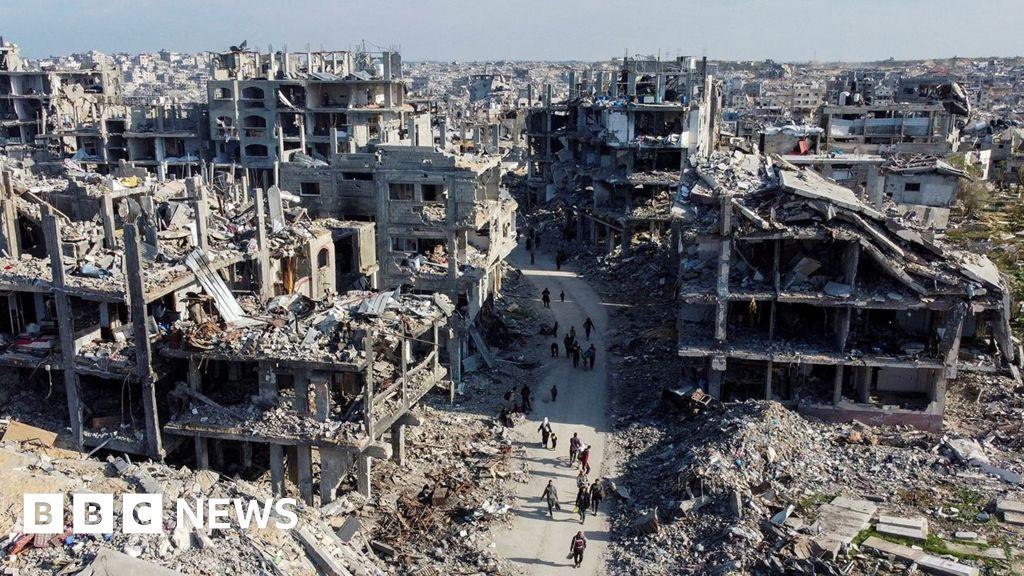

In [30]:
read_image_from_s3(article["image_path"])

## Related data

The article was collected via a search, which used parameters persisted in the datalake inside the `search_parameters` table.
Let's load the details.

In [31]:
# load search parameters
stable = catalog.load_table("news.search_parameters")


In [32]:
# read the details of the search referenced by the `search_id` field
sref = stable.scan(row_filter=EqualTo('id', article["search_id"])).to_pandas()


In [34]:
# visualize the result
sref

,end_date,country,_table,num_records,created_at,data_owner,keyword_id,id,keyword,_timestamp,start_date
0,2025-01-21,uk,news.search_parameters,250,2025-01-21T02:26:19Z,FBK,41,d0b47db8-5534-4550-9175-1447a08d237f,refugees,1737426379397,2025-01-20
